In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-arbitrum-test"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [4]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
1714,False,0x3e01dd8a5e1fb3481f0f589056b428fc308af0fb,Curve.fi WBTC/renBTC,2021-09-20,0,0,0.00,0.00,0,64932383.5420006848088359595082719
2964,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi USDC/USDT,2021-09-20,0,0,0.00,0.00,0,66875915.576416
3686,True,0x960ea3e3c7fb317332d990873d354e18d7645590,Curve.fi USD-BTC-ETH,2021-09-20,0,0,0.00,0.00,0,44509878.48408679879001175639677137
2963,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi USDC/USDT,2021-09-21,380.9907737753653766632822719382981,380.9907737753653766632822719382981,761.98,0.00,0.000005750346799851845345555727405480546,66255268.94920170782387656945730642
3685,True,0x960ea3e3c7fb317332d990873d354e18d7645590,Curve.fi USD-BTC-ETH,2021-09-21,539.4039519035387886576562251511113,539.4039519035387886576562251511117,1078.81,0.00,0.00001222884090909610065909814333777959,44109164.22195969455339143423226301
...,...,...,...,...,...,...,...,...,...,...
3325,False,0x943f3b750447abdd61cdf68ae6c3912cd3beda04,Curve.fi Factory Plain Pool: MAI,2022-07-20,0,0,0.00,0.00,0,0
5412,False,0xdc6ebb38be3fdba42ff65da6aafb9ede6443dfdb,Curve.fi Factory USD Metapool: Holy Trinitussy,2022-07-20,0,0,0.00,0.00,0,0
1796,False,0x59bf0545fca0e5ad48e13da269facd2e8c886ba4,Curve.fi Factory Plain Pool: VST+FRAX,2022-07-20,37.68283147863807112377106127828052,37.68283147863807112377106127828052,75.37,0.00,0.000005078871464319678588996282720200664,7419528.4805629030048016546896614
5414,False,0xe013593cea239e445d2271106836b00c9e7356ae,Curve.fi Factory Plain Pool: Aave USDC+USDT,2022-07-20,0.000497216891537442712348683519464261,0.000497216891537442712348683519464261,0.00,0.00,0.00004940470602074057190714213858890661,10.064160513954


<AxesSubplot:xlabel='timestamp'>

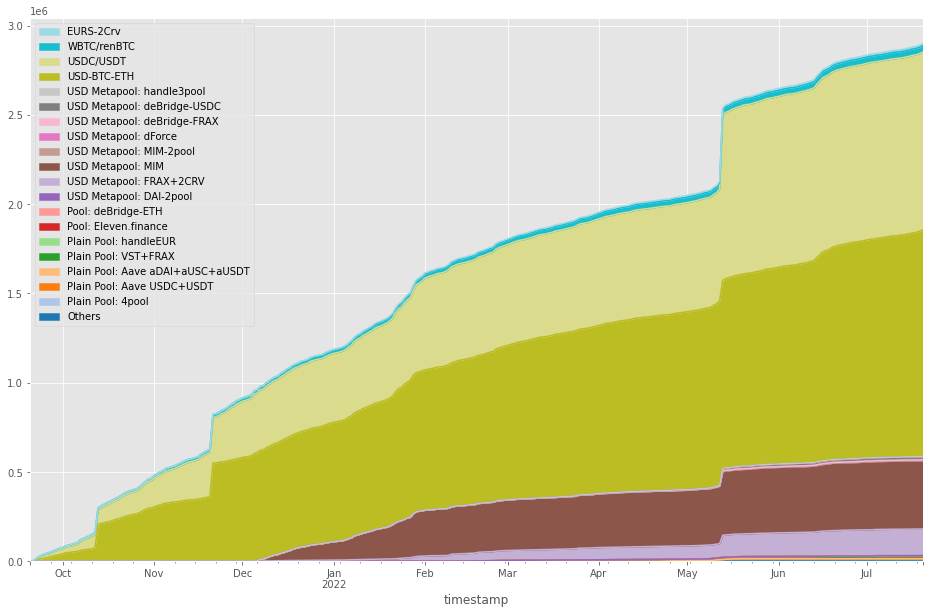

In [5]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [6]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-09-16,13940.58
2021-09-23,51831.55
2021-09-30,38335.74
2021-10-07,194639.01
2021-10-14,60951.39
2021-10-21,55908.71
2021-10-28,83769.56
2021-11-04,50393.67
2021-11-11,49938.18


In [7]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   1456966.69
dtype: float64